# Master Thesis Script
## Running logit regression model


In [2]:
# import all necessary packages
import numpy as np 
import pandas as pd
from transformers import pipeline
import torch
import regex as re
import transformers
import json
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
import matplotlib.pyplot as plt
import scipy
import statistics
import math
import random
import statsmodels.api as sm
from scipy.stats import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import nbinom
import ast
import seaborn as sns
from joblib import Parallel, delayed
import pickle
import itertools

2023-08-10 13:23:42.674284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 13:23:43.033408: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-10 13:23:44.462798: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-10 13:23:44.462879: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Step 1: Prepare dataset for logistic regression model

Now that all necessary variables are created, we create a dataset from the large dataset to use for the logistic regression.
The logistic regression models the retweeting decision of politicians. Thus, the dataset to be used will contain observations of:
- tweets that were retweeted by a politician (positive examples)
- a sample of tweets that were not retweeted by a politician (negative examples)

In [3]:
# Load dataset with all tweets and all required independent variables
f = open(r'Final_Data_20230508.json')
  
# returns JSON object as 
# a dictionary
data = pd.read_json(f, dtype={"author_id_new":str, "retweeted_user_id_new":str})
  
# Closing file
f.close()

In [39]:
# keep only retweets
# identify retweets as observations where the retweeted user ID is not NA
data["retweeted_user_id"] = data["retweeted_user_id"].astype(object).replace('None', np.nan)
data_rts_only = data[~(data["retweeted_user_id"].isna())]
data_rts_only["retweeted_user_id"] = data_rts_only["retweeted_user_id"].astype(object).replace(np.nan, 'None')

/tmp/ipykernel_15486/428271179.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rts_only["retweeted_user_id"] = data_rts_only["retweeted_user_id"].astype(object).replace(np.nan, 'None')


In [51]:
# only keep observations where retweeting author is a politician,
# i.e., their ID occurs in the author_id column
data_rts_only_filtered = data_rts_only[data_rts_only["retweeted_user_id"].isin(data_rts_only["author_id"])].copy()

In [52]:
# get the Party of the tweeting author and assign the according party to the retweeted author
data_rts_only_unique = data_rts_only.drop_duplicates(subset='author_id')
data_rts_only_unique_party = data_rts_only_unique[["author_id", "Party"]]
# add the party to the df
merged_df_filtered = pd.merge(data_rts_only_filtered, data_rts_only_unique_party, left_on='rt_author_new',right_on = "author_id", how='left')

In [56]:
# rename retweeted author column
merged_df_filtered.rename(columns={'referenced_tweets.retweeted.id': 'retweeted_id'}, inplace=True)

/tmp/ipykernel_15486/2841106689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_filtered["retweeted_id"] = merged_df_filtered["referenced_tweets.retweeted.id"]


In [73]:
# merge with total df, to retain all tweet characteristics of interest
merged_df_tweet_data_filtered = pd.merge(merged_df_filtered, data_OG, on='text', how='left')

In [75]:
# only keep observations where the NewsGuard score is available
merged_df_tweet_data_filtered_NG = merged_df_tweet_data_filtered[(merged_df_tweet_data_filtered['NG_score'] != "None") & (merged_df_tweet_data_filtered['NG_score'] != "none") & (merged_df_tweet_data_filtered['NG_score'] != None) & (merged_df_tweet_data_filtered['NG_score'].isna() != True)] 
merged_df_tweet_data_filtered_NG['NG_score'] = merged_df_tweet_data_filtered_NG['NG_score'].astype(float)

/tmp/ipykernel_15486/2310250554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_tweet_data_filtered_NG['NG_score'] = merged_df_tweet_data_filtered_NG['NG_score'].astype(float)


In [76]:
# remove observations where retweeting author has no party
# Party_x: retweeting author party
# Party_y: retweeted author party

merged_df_tweet_data_filtered_NG = merged_df_tweet_data_filtered_NG[(merged_df_tweet_data_filtered_NG['Party_x'] != 'None') & (merged_df_tweet_data_filtered_NG['Party_y'] != 'None')]

In [77]:
# summary statistics of within and across party retweets
combination_counts = merged_df_tweet_data_filtered_NG.groupby(['Party_x', 'Party_y']).size().reset_index(name='Count')

print(combination_counts)

      Party_x     Party_y  Count
0    Democrat    Democrat   6446
1    Democrat  Republican    524
2  Republican    Democrat    452
3  Republican  Republican   4445


In [88]:
# add column to identify positive samples later in model estimation
merged_df_tweet_data_filtered_NG["RT"] = 1

In [89]:
# only keep observations starting in 2021
merged_df_tweet_data_filtered_NG['created_at_dt'] = pd.to_datetime(merged_df_tweet_data_filtered_NG['created_at_x'])
merged_df_tweet_data_filtered_NG_recent = merged_df_tweet_data_filtered_NG[merged_df_tweet_data_filtered_NG['created_at_dt'].dt.year >= 2021]

In [90]:
# create new df which contains retweeting and retweeted author combination and their parties
# this will be used to create the negative samples
merged_df_tweet_data_filtered_NG_recent_unique = merged_df_tweet_data_filtered_NG_recent.drop_duplicates(subset=['author_id_x', "rt_author_new"])
merged_df_tweet_data_filtered_NG_recent_unique = merged_df_tweet_data_filtered_NG_recent_unique[["author_id_x", "rt_author_new", "Party_x", "Party_y"]]


Now, positive samples have been generated.
The next step is to generate an equal number of negative examples, i.e., tweets that were not retweeted by other politicians.
This is done by first, identifying which politician follower pairs exist (e.g., Sanders follows Biden).
Then, the assumption is made that a tweet posted by a politician (e.g., Biden) that was not retweeted by the follower politician (e.g., Sanders), has been viewed by this follower politician and they decided not to retweet.
Such observations can thus be used as negative samples in the following logistic regression model.

In [70]:
# only keep original tweets, i.e., drop retweets
data = data.astype(object).replace('None', np.nan)
data_OG = data[data["retweeted_user_id"].isna()]

In [81]:
# tweets that occur in positive samples
text_lst_exclude = merged_df_tweet_data_filtered_NG.text.values.tolist()

In [82]:
# keep only tweets that are not in the positive examples 
filtered_df = data_OG[~data_OG['text'].isin(text_lst_exclude)]

In [85]:
# composition of retweeting politician parties in positive samples (we want the same in the negative samples)
merged_df_tweet_data_filtered_NG["Party_x"].value_counts()

Democrat      6970
Republican    4897
Name: Party_x, dtype: int64

In [ ]:
# create a stratified sample to get negative examples
# stratify by party of retweeting author to keep party composition representative

In [96]:
# from the complete dataframe of tweets, create a sample that is stratified by political party of tweeting author
stratify_column = 'Party'

# Define the sample size and random state
sample_sizes = {
    'Democrat': 6970,
    'Republican': 4897
}
random_state = 42

# Create a stratified sample based on the selected column
stratified_sample = filtered_df.groupby(stratify_column, group_keys=False).apply(lambda x: x.sample(n=sample_sizes[x.name], random_state=random_state))


In [99]:
# add column to identify negative samples later in model estimation
stratified_sample["RT"] = 0

In [ ]:
# add author parties
# merge on the retweeting author
stratified_sample_final_merge = pd.merge(stratified_sample, merged_df_tweet_data_filtered_NG_recent_unique, on=['author_id_x', "rt_author_new"], how='left')

In [ ]:
# concatenate positive and negative samples into one df to be used for regression
complete_sample_regression = pd.concat([merged_df_tweet_data_filtered_NG,stratified_sample_final_merge])

In [ ]:
# save df
complete_sample_regression.to_csv("Complete_Regression_Sample_20230629.csv")

Now a dataset of both positive and negative samples of politician retweets is created.
This can be used in the subsequent logistic regression model.

Step 2: Conduct logistic regression
- Using the dataset created above, a stepwise logistic regression model is estimated.
The dependent variable hereby is the "RT" variable created above, where 1 indicates that the tweet was retweeted by a Congress Member, and 0 if not.
Independent variables included are: dummy indicating if author parties align, each emotion's score (keeping affection out, to serve as the reference case), neutrality dummy, NewsGuard score, log number of outgroup words and log number of ingroup words.

- The regression is conducted by iteratively estimating a model and incrementally adding further variables and interactions of variables. Such added variables are retained in the model if they are both statistically significant and reduce the AIC and BIC information criteria. Hereby, any two-way interaction that is deemed to potentially have an impact on the model, is tested as well.

- After the optimal model is found, further diagnostic tests relating to multicollinearity and residuals as well as goodness-of-fit are conducted.

In [8]:
# load regression dataset
data = pd.read_csv(r"Calibration_LogisticRegression/Complete_Regression_Sample_20230629.csv")

In [9]:
# hard code neutral sentiment
# this threshold was identified in another step, using manual tweet annotation as a ground truth for neutrality and
# identifying the threshold with a ROC curve
data.loc[(data['Neutral_Sentiment'] >0.5517), 'Neutral_Dummy'] = 1
data['Neutral_Dummy'].fillna(0, inplace=True)

In [10]:
# dummy to indicate same political party
data.loc[data["Party_x"] == data["Party_y"], 'Same_Party_Dummy'] = 1
data.loc[data["Party_x"] != data["Party_y"], 'Same_Party_Dummy'] = 0
data["Same_Party_Dummy"] = data["Same_Party_Dummy"].astype(int)

In [11]:
# ensure NewsGuard score variable is valid float value in each observations
data_NG = data[(data['NG_score'] != "None") & (data['NG_score'] != "none") & (data['NG_score'] != None) & (data['NG_score'].isna() != True)] 
data_NG["NG_score"] = data_NG["NG_score"].astype(float)

/tmp/ipykernel_69222/2602497923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_NG["NG_score"] = data_NG["NG_score"].astype(float)


In [12]:
# create two-way interactions
data_NG['Interaction_happiness_SameParty'] = data_NG['Happiness']*data_NG['Same_Party_Dummy'] 
data_NG['Interaction_anger_SameParty'] = data_NG['Anger']*data_NG['Same_Party_Dummy']
data_NG['Interaction_fear_SameParty'] = data_NG['Fear']*data_NG['Same_Party_Dummy']
data_NG['Interaction_sadness_SameParty'] = data_NG['Sadness']*data_NG['Same_Party_Dummy']

data_NG['Interaction_happiness_NG'] = data_NG['Happiness']*data_NG['NG_score']
data_NG['Interaction_fear_NG'] = data_NG['Fear']*data_NG['NG_score']
data_NG['Interaction_anger_NG'] = data_NG['Anger']*data_NG['NG_score']
data_NG['Interaction_sadness_NG'] = data_NG['Sadness']*data_NG['NG_score']

data_NG['Interaction_anger_Neutral'] = data_NG['Anger']*data_NG['Neutral_Dummy']
data_NG['Interaction_fear_Neutral'] = data_NG['Fear']*data_NG['Neutral_Dummy']
data_NG['Interaction_happiness_Neutral'] = data_NG['Happiness']*data_NG['Neutral_Dummy']
data_NG['Interaction_sadness_Neutral'] = data_NG['Sadness']*data_NG['Neutral_Dummy']

data_NG['Interaction_SameParty_NG'] = data_NG['Same_Party_Dummy']*data_NG['NG_score']

/tmp/ipykernel_69222/290757156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_NG['Interaction_happiness_SameParty'] = data_NG['Happiness']*data_NG['Same_Party_Dummy']
/tmp/ipykernel_69222/290757156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_NG['Interaction_anger_SameParty'] = data_NG['Anger']*data_NG['Same_Party_Dummy']
/tmp/ipykernel_69222/290757156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [13]:
# create log-transformed variables for in- and outgroup words
data_NG = data_NG.assign(
    Number_Outgroup_Words_log=np.log(data_NG["Number_Outgroup_Words"] + 1),
    Number_Ingroup_Words_log=np.log(data_NG["Number_Ingroup_Words"] + 1)
)

In [14]:
# create in- and outgroup word interactions
data_NG['Interaction_Outgroup_Neutral'] = data_NG['Number_Outgroup_Words_log']*data_NG['Neutral_Dummy']
data_NG['Interaction_Ingroup_Neutral'] = data_NG['Number_Ingroup_Words_log']*data_NG['Neutral_Dummy']
data_NG['Interaction_Ingroup_anger'] = data_NG['Number_Ingroup_Words_log']*data_NG['Anger']
data_NG['Interaction_Outgroup_anger'] = data_NG['Number_Outgroup_Words_log']*data_NG['Anger']
data_NG['Interaction_Ingroup_fear'] = data_NG['Number_Ingroup_Words_log']*data_NG['Fear']
data_NG['Interaction_Outgroup_fear'] = data_NG['Number_Outgroup_Words_log']*data_NG['Fear']
data_NG['Interaction_Ingroup_happiness'] = data_NG['Number_Ingroup_Words_log']*data_NG['Happiness']
data_NG['Interaction_Outgroup_happiness'] = data_NG['Number_Outgroup_Words_log']*data_NG['Happiness']
data_NG['Interaction_Ingroup_sadness'] = data_NG['Number_Ingroup_Words_log']*data_NG['Sadness']
data_NG['Interaction_Outgroup_sadness'] = data_NG['Number_Outgroup_Words_log']*data_NG['Sadness']
data_NG['Interaction_Outgroup_SameParty'] = data_NG['Number_Outgroup_Words_log']*data_NG['Same_Party_Dummy']
data_NG['Interaction_Ingroup_SameParty'] = data_NG['Number_Ingroup_Words_log']*data_NG['Same_Party_Dummy']
data_NG['Interaction_Outgroup_NG'] = data_NG['Number_Outgroup_Words_log']*data_NG['NG_score']
data_NG['Interaction_Ingroup_NG'] = data_NG['Number_Ingroup_Words_log']*data_NG['NG_score']

In [15]:
# estimate model first only with main variables, no interactions
X = sm.add_constant(data_NG[['Anger','Happiness', 'Fear','Sadness','NG_score',
                             'Same_Party_Dummy', 'Neutral_Dummy', 'Number_Outgroup_Words_log',
                             'Number_Ingroup_Words_log'
                            ]])

Y = data_NG['RT']
logit_model = sm.Logit(Y, X)
result = logit_model.fit()

# Displaying the logistic regression summary
print(result.summary())
print(f"AIC criterion: {result.aic}")
print(f"BIC criterion: {result.bic}")

Optimization terminated successfully.
         Current function value: 0.669407
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                     RT   No. Observations:                22128
Model:                          Logit   Df Residuals:                    22118
Method:                           MLE   Df Model:                            9
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                 0.03056
Time:                        14:03:48   Log-Likelihood:                -14813.
converged:                       True   LL-Null:                       -15280.
Covariance Type:            nonrobust   LLR p-value:                2.964e-195
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2541      0.124      2.053      0.040       0.

In [16]:
# now first add neutral dummies
X = sm.add_constant(data_NG[['Anger','Happiness', 'Fear','Sadness','NG_score',
                             'Same_Party_Dummy', 'Neutral_Dummy', 'Number_Outgroup_Words_log',
                             'Number_Ingroup_Words_log','Interaction_anger_Neutral',
                             'Interaction_fear_Neutral', 'Interaction_happiness_Neutral',
                             'Interaction_sadness_Neutral' 
                            ]])
Y = data_NG['RT']

logit_model = sm.Logit(Y, X)
result = logit_model.fit()

# Displaying the logistic regression summary
print(result.summary())
print(f"AIC criterion: {result.aic}")
print(f"BIC criterion: {result.bic}")

Optimization terminated successfully.
         Current function value: 0.668113
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                     RT   No. Observations:                22128
Model:                          Logit   Df Residuals:                    22114
Method:                           MLE   Df Model:                           13
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                 0.03244
Time:                        14:03:50   Log-Likelihood:                -14784.
converged:                       True   LL-Null:                       -15280.
Covariance Type:            nonrobust   LLR p-value:                1.332e-203
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0702      0.126      0.555      0.

In [17]:
# adding neutral dummies improved model

The following model output summary corresponds to the final model. 
A comprehensive summary output can be viewed in the PDF file in Table 2.

In [18]:
# trying out further interactions and keeping each of those if (1) statistically significant at least
# at 10% level and (2) improves AIC and BIC criteria

# the following is the final model, resulting in lowest AIC and BIC 
X = sm.add_constant(data_NG[['Anger','Happiness', 'Fear','Sadness','NG_score',
                             'Same_Party_Dummy', 'Neutral_Dummy', 'Number_Outgroup_Words_log',
                             'Number_Ingroup_Words_log','Interaction_anger_Neutral',
                             'Interaction_fear_Neutral', 'Interaction_happiness_Neutral',
                             'Interaction_sadness_Neutral', 
                             'Interaction_fear_SameParty', 'Interaction_happiness_SameParty',
                             'Interaction_sadness_SameParty', 'Interaction_SameParty_NG',
                             'Interaction_Outgroup_anger','Interaction_Ingroup_anger',
                             'Interaction_Outgroup_fear', 'Interaction_Outgroup_happiness',
                             'Interaction_Outgroup_SameParty', 'Interaction_Ingroup_SameParty',
                             
                            ]])
Y = data_NG['RT']

logit_model = sm.Logit(Y, X)
result = logit_model.fit()

# Displaying the logistic regression summary
print(result.summary())
print(f"AIC criterion: {result.aic}")
print(f"BIC criterion: {result.bic}")

Optimization terminated successfully.
         Current function value: 0.665693
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                     RT   No. Observations:                22128
Model:                          Logit   Df Residuals:                    22104
Method:                           MLE   Df Model:                           23
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                 0.03594
Time:                        14:03:54   Log-Likelihood:                -14730.
converged:                       True   LL-Null:                       -15280.
Covariance Type:            nonrobust   LLR p-value:                1.560e-217
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.6733      0.415     -1.621  

In [ ]:
# Save the model to a file
import pickle
with open('logitModel_20230630_NeutralDummy.pkl', 'wb') as file:
    pickle.dump(result, file)

In [14]:
# Compute marginal effects
marginal_effects = result.get_margeff(at='overall')

# Get marginal effects summary
marginal_effects_summary = marginal_effects.summary()

# Convert summary to a DataFrame
marginal_effects_df = pd.DataFrame(marginal_effects_summary.tables[1].data)
marginal_effects_df.columns = marginal_effects_df.iloc[0]
marginal_effects_df = marginal_effects_df[1:]

# Print marginal effects of main independent variables (without interactions)
marginal_effects_df[:9]

,,dy/dx,std err,z,P>|z|,[0.025,0.975]
1,Anger,0.1407,0.021,6.767,0.000,0.100,0.181
2,Happiness,-0.2293,0.062,-3.672,0.000,-0.352,-0.107
3,Fear,-0.1386,0.077,-1.799,0.072,-0.290,0.012
4,Sadness,-0.6684,0.137,-4.892,0.000,-0.936,-0.401
5,NG_score,0.0016,0.001,1.557,0.120,-0.000,0.004
6,Same_Party_Dummy,0.2246,0.101,2.228,0.026,0.027,0.422
7,Neutral_Dummy,0.1401,0.029,4.827,0.000,0.083,0.197
8,Number_Outgroup_Words_log,0.3636,0.046,7.879,0.000,0.273,0.454
9,Number_Ingroup_Words_log,0.1566,0.029,5.371,0.000,0.099,0.214


In [15]:
# printing Odds ratios, for better interpretation of coefficients

coef_estimates = result.params

# Calculate the odds ratio for each coefficient by exponentiating the betas
odds_ratios = np.exp(coef_estimates)

print("Odds Ratios:")
print(odds_ratios)

Odds Ratios:
const                              0.510036
Anger                              1.812036
Happiness                          0.379515
Fear                               0.556876
Sadness                            0.059392
NG_score                           1.006759
Same_Party_Dummy                   2.582200
Neutral_Dummy                      1.807571
Number_Outgroup_Words_log          4.645410
Number_Ingroup_Words_log           1.938005
Interaction_anger_Neutral          0.412473
Interaction_fear_Neutral           0.262102
Interaction_happiness_Neutral      0.400357
Interaction_sadness_Neutral        0.255487
Interaction_fear_SameParty         2.797836
Interaction_happiness_SameParty    2.096060
Interaction_sadness_SameParty      8.641377
Interaction_SameParty_NG           0.988381
Interaction_Outgroup_anger         0.401143
Interaction_Ingroup_anger          0.514430
Interaction_Outgroup_fear          0.368238
Interaction_Outgroup_happiness     0.357209
Interaction_Outgrou

Regression model diagnostics

In [16]:
# Get likelihood ratio test values
lr_test_statistic = result.llr  # Likelihood ratio test statistic
lr_p_value = result.llr_pvalue  # p-value of the likelihood ratio test
lr_degrees_of_freedom = result.df_model  # Degrees of freedom of the test

print("Likelihood Ratio Test:")
print(f"Test Statistic: {lr_test_statistic}")
print(f"P-value: {lr_p_value}")
print(f"Degrees of Freedom: {lr_degrees_of_freedom}")

Likelihood Ratio Test:
Test Statistic: 1098.3636977168499
P-value: 1.560326866139936e-217
Degrees of Freedom: 23.0


In [19]:
# Hosmer-Lemeshow test for goodness-of-fit

def hosmer_lemeshow_test(y_true, y_pred_prob, num_bins=10):
    # Sort the predicted probabilities and true labels
    sorted_indices = np.argsort(y_pred_prob)
    y_true_sorted = y_true[sorted_indices]
    y_pred_prob_sorted = y_pred_prob[sorted_indices]

    # Divide predicted probabilities into groups (bins)
    bin_size = len(y_true) // num_bins
    observed_freq = np.zeros(num_bins)
    expected_freq = np.zeros(num_bins)

    for i in range(num_bins):
        start_idx = i * bin_size
        end_idx = (i + 1) * bin_size
        group_y_true = y_true_sorted[start_idx:end_idx]
        group_y_pred_prob = y_pred_prob_sorted[start_idx:end_idx]

        observed_freq[i] = np.sum(group_y_true)
        expected_freq[i] = np.sum(group_y_pred_prob)

    # Calculate degrees of freedom and the chi-square statistic
    degrees_of_freedom = num_bins - 2  # Number of groups (bins) minus 2 (2 parameters in logistic regression)
    chi_square_statistic = np.sum((observed_freq - expected_freq)**2 / expected_freq)

    # Calculate the p-value using the chi-square distribution
    from scipy.stats import chi2
    p_value = 1.0 - chi2.cdf(chi_square_statistic, degrees_of_freedom)

    return chi_square_statistic, degrees_of_freedom, p_value

In [20]:
# Hosmer-Lemeshow Test
y_prob = result.predict(X)
y_prob = pd.DataFrame(y_prob)
y_prob1 = pd.concat([y_prob, Y], axis =1)
y_prob1['decile'] = pd.qcut(y_prob1[0], 10)
obsevents_pos = y_prob1['RT'].groupby(y_prob1.decile).sum()
obsevents_neg = y_prob1[0].groupby(y_prob1.decile).count() - obsevents_pos
expevents_pos = y_prob1[0].groupby(y_prob1.decile).sum()
expevents_neg = y_prob1[0].groupby(y_prob1.decile).count() - expevents_pos
hl = ((obsevents_neg - expevents_neg)**2/expevents_neg).sum()+((obsevents_pos - expevents_pos)**2/expevents_pos).sum()
print("Hosmer-Lemeshow goodness-of-fit test")
print('chi-square: {:.2f}'.format(hl))
## df = group-2
pvalue=1-chi2.cdf(hl,8)
print('p-value: {:.2f}'.format(pvalue))
print("Lack of statistical significance at 1% and 5% level indicates relatively good model fit.")

Hosmer-Lemeshow goodness-of-fit test
chi-square: 14.19
p-value: 0.08
Lack of statistical significance at 1% and 5% level indicates relatively good model fit.


The Hosmer-Lemeshow test compares the frequency of observed and predicted events across groups of predicted probabilities and has a chi-square distributed test statistic. The null hypothesis of the test states that observed and expected frequencies do not differ significantly, with the alternative hypothesis indicating a significant difference. In the case of the alternative hypothesis, a lack of fit of the logistic regression model is indicated and thus the aim is to arrive at a model where one fails to reject the null hypothesis.
In our case, we fail to reject the null hypothesis at the 1% and 5% level, indicating a good model fit.

In [140]:
# fit intercept only model to compare AIC and BIC
X = sm.add_constant(data_NG[[]])
Y = data_NG['RT']

logit_model = sm.Logit(Y, X)
intercept_only_result = logit_model.fit()

# Displaying the logistic regression summary
print(intercept_only_result.summary())
print(f"AIC criterion: {intercept_only_result.aic}")
print(f"BIC criterion: {intercept_only_result.bic}")

Optimization terminated successfully.
         Current function value: 0.690511
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                     RT   No. Observations:                22128
Model:                          Logit   Df Residuals:                    22127
Method:                           MLE   Df Model:                            0
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:               1.251e-10
Time:                        09:16:31   Log-Likelihood:                -15280.
converged:                       True   LL-Null:                       -15280.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1454      0.013     10.787      0.000       0.119       0.172
AIC criterion: 30561.25924260

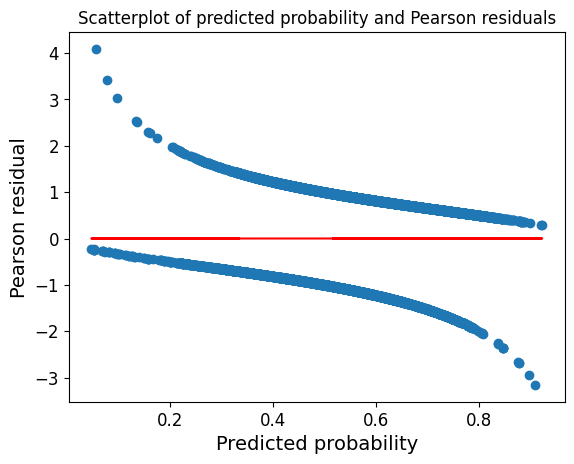

In [103]:
# diagnostics on residuals

y_prob_lst = y_prob.values.tolist()
y_prob_lst = [item[0] for item in y_prob_lst]

coefficients = np.polyfit(y_prob_lst, result.resid_pearson, 1)
regression_line = np.poly1d(coefficients)

# Plot the scatter plot and regression line
plt.scatter(y_prob_lst, result.resid_pearson, label='Data')
plt.plot(y_prob_lst, regression_line(y_prob_lst), color='r', label='Regression Line')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted probability", fontsize=14)
plt.ylabel("Pearson residual", fontsize=14)
plt.title("Scatterplot of predicted probability and Pearson residuals")
plt.show()

The Pearson residual plot suggests that there are some observations with relatively large residuals.
The next step is to ensure there are no observations that are both high in leverage (i.e., influence model coefficients disproportionately) and have a high residual simultaneously. If any such observations exist, it would be advisable to re-estimate the model without such observations to cross-check changes in coefficients.

In [104]:
# check residual - leverage plot

influence = result.get_influence()
# Compute the leverage values (hat matrix diagonal)
leverage_values = influence.hat_matrix_diag
# Compute the standardized residuals
standardized_residuals = (influence.resid_studentized)**2

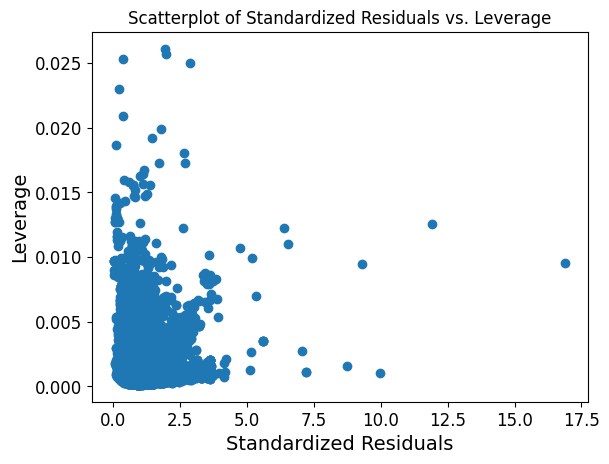

In [105]:
plt.scatter(standardized_residuals, leverage_values)

# Set the axis labels
plt.xlabel("Standardized Residuals", fontsize=14)
plt.ylabel("Leverage", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set the plot title (optional)
plt.title("Scatterplot of Standardized Residuals vs. Leverage")
plt.savefig('Leverage_Scatterplot.svg',  bbox_inches='tight',format='svg')
# Show the plot
plt.show()

The scatterplot suggests that no observations with both high residuals and high leverage exist. We can therefore continue without re-estimating the model.

In [23]:
# check variable multicollinearity
# Create a correlation matrix
correlation_matrix = data_NG[['Anger','Happiness', 'Fear','Sadness','NG_score',
                             'Same_Party_Dummy', 'Neutral_Dummy', 'Number_Outgroup_Words_log',
                             'Number_Ingroup_Words_log' 
                            ]].corr()

In [24]:
print(correlation_matrix)

                              Anger  Happiness      Fear   Sadness  NG_score  \
Anger                      1.000000  -0.505472 -0.063354 -0.105543 -0.087891   
Happiness                 -0.505472   1.000000 -0.350929 -0.231435  0.038962   
Fear                      -0.063354  -0.350929  1.000000 -0.013521 -0.000467   
Sadness                   -0.105543  -0.231435 -0.013521  1.000000  0.015654   
NG_score                  -0.087891   0.038962 -0.000467  0.015654  1.000000   
Same_Party_Dummy           0.025718  -0.021075  0.010943 -0.007786 -0.034932   
Neutral_Dummy             -0.110732  -0.036908  0.190265  0.004859 -0.016644   
Number_Outgroup_Words_log  0.307573  -0.171778  0.126180 -0.059162 -0.065762   
Number_Ingroup_Words_log  -0.014963   0.037151 -0.028620 -0.114721 -0.029313   

                           Same_Party_Dummy  Neutral_Dummy  \
Anger                              0.025718      -0.110732   
Happiness                         -0.021075      -0.036908   
Fear         

The correlation matrix shows low correlation between almost all variable pairs, with the exception of some emotions showing higher correlation, e.g., Anger and Happiness, Fear and Happiness. All other pairwise correlations do not exceed ~10%.

In [106]:
X = sm.add_constant(data_NG[['Anger','Happiness', 'Fear','Sadness','NG_score',
                             'Same_Party_Dummy', 'Neutral_Dummy', 'Number_Outgroup_Words_log',
                             'Number_Ingroup_Words_log',
                            
                             
                            ]])
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


In [107]:
vif

,Feature,VIF
0,const,79.904337
1,Anger,1.792709
2,Happiness,1.965877
3,Fear,1.373336
4,Sadness,1.200006
5,NG_score,1.012403
6,Same_Party_Dummy,1.003267
7,Neutral_Dummy,1.059231
8,Number_Outgroup_Words_log,1.142718
9,Number_Ingroup_Words_log,1.020492


We only look at main variables for VIF. The rule of thumb is for the VIF to not exceed 10, which is the case here.
This suggests there are no issues with multicollinearity.

Finally, the dynamics of the predicted retweeting probability are visualised, upon only varying a selected emotion variable, keeping all else constant. For this, the model is applied to some simulated data.
These visualisations help in identifying the isolated effect of varying intensity levels of certain emotions on the predicted probability to retweet, across several scenarios.

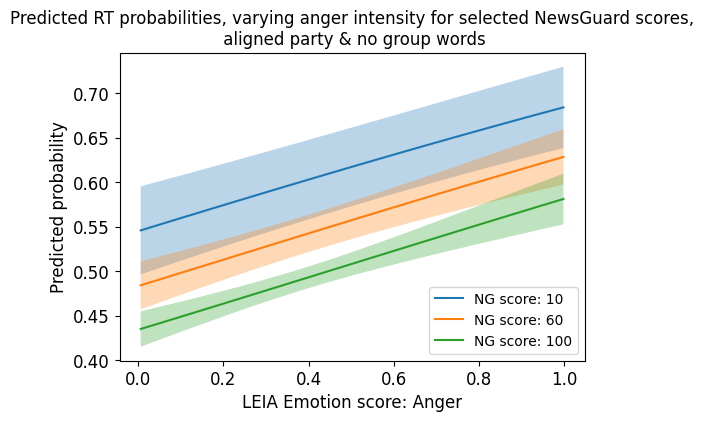

In [ ]:
# visualising relationship of anger and predicted probability to retweet across selected NewsGuard score values, keeping all else constant
# Scenario: no in- or out-group words included, tweeting and retweeting author parties align

Predicted_prob_sameparty_neg_high = pd.DataFrame()
CI_list = []
sameparty = [1]*100
neutral = [0]*100
group_words = [0] *100
sample_size = 100
varying_emotion = [random.random() for _ in range(sample_size)]
constant_emotion = [0.1]*100
plt.figure(figsize=(10, 6))
NG_score_lst = [10,60,100]
for item in NG_score_lst:
    NG_score = [item]*100
    hypothetical_data_highNG_sameparty = pd.DataFrame()
    hypothetical_data_highNG_sameparty["Anger"] = varying_emotion
    hypothetical_data_highNG_sameparty["Fear"] = constant_emotion
    hypothetical_data_highNG_sameparty["Happiness"] = constant_emotion
    hypothetical_data_highNG_sameparty["Sadness"] = constant_emotion
    hypothetical_data_highNG_sameparty["NG_score"] = NG_score
    hypothetical_data_highNG_sameparty["Same_Party_Dummy"] = sameparty
    hypothetical_data_highNG_sameparty["Neutral_Dummy"] = neutral
    hypothetical_data_highNG_sameparty["Interaction_anger_Neutral"] = hypothetical_data_highNG_sameparty["Neutral_Dummy"] *hypothetical_data_highNG_sameparty["Anger"] 
    hypothetical_data_highNG_sameparty["Interaction_fear_Neutral"] = hypothetical_data_highNG_sameparty["Neutral_Dummy"] *hypothetical_data_highNG_sameparty["Fear"] 
    hypothetical_data_highNG_sameparty["Interaction_happiness_Neutral"] = hypothetical_data_highNG_sameparty["Neutral_Dummy"] *hypothetical_data_highNG_sameparty["Happiness"] 
    hypothetical_data_highNG_sameparty["Interaction_sadness_Neutral"] = hypothetical_data_highNG_sameparty["Neutral_Dummy"] *hypothetical_data_highNG_sameparty["Sadness"] 
    hypothetical_data_highNG_sameparty["Number_Outgroup_Words_log"] = group_words
    hypothetical_data_highNG_sameparty["Number_Ingroup_Words_log"] = group_words
    hypothetical_data_highNG_sameparty['Interaction_fear_SameParty'] = hypothetical_data_highNG_sameparty['Fear']*hypothetical_data_highNG_sameparty['Same_Party_Dummy'] 
    hypothetical_data_highNG_sameparty['Interaction_happiness_SameParty'] = hypothetical_data_highNG_sameparty['Happiness']*hypothetical_data_highNG_sameparty['Same_Party_Dummy'] 
    hypothetical_data_highNG_sameparty['Interaction_sadness_SameParty'] = hypothetical_data_highNG_sameparty['Sadness']*hypothetical_data_highNG_sameparty['Same_Party_Dummy']
    hypothetical_data_highNG_sameparty['Interaction_SameParty_NG'] = hypothetical_data_highNG_sameparty['Same_Party_Dummy']*hypothetical_data_highNG_sameparty['NG_score']
    hypothetical_data_highNG_sameparty['Interaction_Outgroup_anger'] = hypothetical_data_highNG_sameparty['Anger']*hypothetical_data_highNG_sameparty['Number_Outgroup_Words_log'] 
    hypothetical_data_highNG_sameparty['Interaction_Ingroup_anger'] = hypothetical_data_highNG_sameparty['Anger']*hypothetical_data_highNG_sameparty['Number_Ingroup_Words_log'] 
    hypothetical_data_highNG_sameparty['Interaction_Outgroup_fear'] = hypothetical_data_highNG_sameparty['Fear']*hypothetical_data_highNG_sameparty['Number_Outgroup_Words_log'] 
    hypothetical_data_highNG_sameparty['Interaction_Outgroup_happiness'] = hypothetical_data_highNG_sameparty['Happiness']*hypothetical_data_highNG_sameparty['Number_Outgroup_Words_log'] 
    hypothetical_data_highNG_sameparty['Interaction_Outgroup_SameParty'] = hypothetical_data_highNG_sameparty['Same_Party_Dummy']*hypothetical_data_highNG_sameparty['Number_Outgroup_Words_log'] 
    hypothetical_data_highNG_sameparty['Interaction_Ingroup_SameParty'] = hypothetical_data_highNG_sameparty['Same_Party_Dummy']*hypothetical_data_highNG_sameparty['Number_Ingroup_Words_log'] 



    X_new = sm.add_constant(hypothetical_data_highNG_sameparty[['Anger','Happiness', 'Fear','Sadness','NG_score',
                             'Same_Party_Dummy', 'Neutral_Dummy', 'Interaction_anger_Neutral',
                             'Interaction_fear_Neutral', 'Interaction_happiness_Neutral',
                             'Interaction_sadness_Neutral', 'Number_Outgroup_Words_log',
                             'Number_Ingroup_Words_log',
                             'Interaction_fear_SameParty', 'Interaction_happiness_SameParty',
                             'Interaction_sadness_SameParty', 'Interaction_SameParty_NG',
                             'Interaction_Outgroup_anger','Interaction_Ingroup_anger',
                             'Interaction_Outgroup_fear', 'Interaction_Outgroup_happiness',
                             'Interaction_Outgroup_SameParty', 'Interaction_Ingroup_SameParty']])

    constant = [1] *100
    X_new["constant"] = constant
    cols = X_new.columns.tolist()
    cols = cols[-1:] + cols[:-1]

    # Reorder the DataFrame columns
    X_new1 = X_new[cols]
    X_sorted = X_new1.sort_values(by='Anger')
    prob_Y = result.predict(X_sorted)
    prob_Y = result.predict(X_sorted)
    conf_int = result.get_prediction(X_sorted).conf_int('delta')
    
    Predicted_prob_sameparty_neg_high[item] = prob_Y
    CI_list.append(conf_int)
#Predicted_prob_sameparty_neg_high["Anger"] = X_sorted["Anger"]
#Predicted_CI_sameparty_neg_high["Anger"] = X_sorted["Anger"]




i = 0
for column in Predicted_prob_sameparty_neg_high.columns:
    conf_int = CI_list[i]
    i += 1
    min_prediction = conf_int[:, 0]
    max_prediction = conf_int[:, 1]

    plt.plot(X_sorted["Anger"], Predicted_prob_sameparty_neg_high[column], label=f"NG score: {column}")
    
    plt.fill_between(X_sorted["Anger"], min_prediction, max_prediction, alpha=0.3)

# Add legend with labels
plt.legend(loc='lower right')
# Set x-axis label with increased font size
plt.xlabel('LEIA Emotion score: Anger', fontsize=14)

# Set y-axis label with increased font size
plt.ylabel('Predicted probability', fontsize=14)

# Set tick labels font size
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title("Predicted RT probabilities, varying anger intensity for selected NewsGuard scores,\n aligned party & no group words", fontsize=14)

plt.savefig('Figures/Anger_aligned_nogroup.svg', bbox_inches='tight',format='svg')
plt.show()

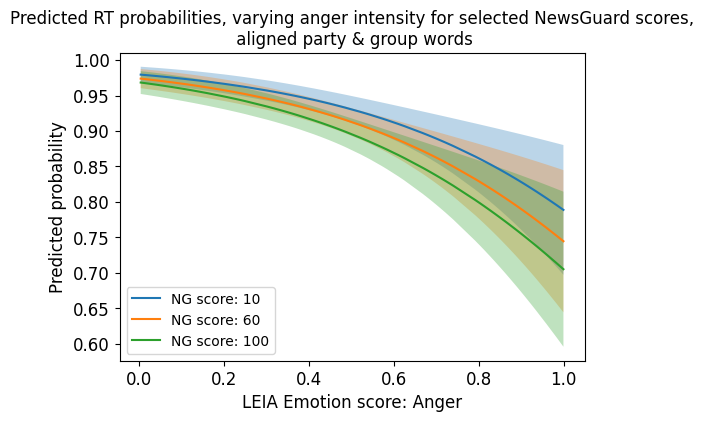

In [ ]:
# visualising relationship of anger and predicted probability to retweet across selected NewsGuard score values, keeping all else constant
# Scenario: in- and out-group words included, tweeting and retweeting author parties align

Predicted_prob_sameparty_neg_high = pd.DataFrame()
CI_list = []
sameparty = [1]*100
neutral = [0]*100
group_words = [2] *100
sample_size = 100
varying_emotion = [random.random() for _ in range(sample_size)]
constant_emotion = [0.1]*100
plt.figure(figsize=(10, 6))
NG_score_lst = [10,60,100]
for item in NG_score_lst:
    NG_score = [item]*100
    hypothetical_data_highNG_sameparty = pd.DataFrame()
    hypothetical_data_highNG_sameparty["Anger"] = varying_emotion
    hypothetical_data_highNG_sameparty["Fear"] = constant_emotion
    hypothetical_data_highNG_sameparty["Happiness"] = constant_emotion
    hypothetical_data_highNG_sameparty["Sadness"] = constant_emotion
    hypothetical_data_highNG_sameparty["NG_score"] = NG_score
    hypothetical_data_highNG_sameparty["Same_Party_Dummy"] = sameparty
    hypothetical_data_highNG_sameparty["Neutral_Dummy"] = neutral
    hypothetical_data_highNG_sameparty["Interaction_anger_Neutral"] = hypothetical_data_highNG_sameparty["Neutral_Dummy"] *hypothetical_data_highNG_sameparty["Anger"] 
    hypothetical_data_highNG_sameparty["Interaction_fear_Neutral"] = hypothetical_data_highNG_sameparty["Neutral_Dummy"] *hypothetical_data_highNG_sameparty["Fear"] 
    hypothetical_data_highNG_sameparty["Interaction_happiness_Neutral"] = hypothetical_data_highNG_sameparty["Neutral_Dummy"] *hypothetical_data_highNG_sameparty["Happiness"] 
    hypothetical_data_highNG_sameparty["Interaction_sadness_Neutral"] = hypothetical_data_highNG_sameparty["Neutral_Dummy"] *hypothetical_data_highNG_sameparty["Sadness"] 
    hypothetical_data_highNG_sameparty["Number_Outgroup_Words_log"] = group_words
    hypothetical_data_highNG_sameparty["Number_Ingroup_Words_log"] = group_words
    hypothetical_data_highNG_sameparty['Interaction_fear_SameParty'] = hypothetical_data_highNG_sameparty['Fear']*hypothetical_data_highNG_sameparty['Same_Party_Dummy'] 
    hypothetical_data_highNG_sameparty['Interaction_happiness_SameParty'] = hypothetical_data_highNG_sameparty['Happiness']*hypothetical_data_highNG_sameparty['Same_Party_Dummy'] 
    hypothetical_data_highNG_sameparty['Interaction_sadness_SameParty'] = hypothetical_data_highNG_sameparty['Sadness']*hypothetical_data_highNG_sameparty['Same_Party_Dummy']
    hypothetical_data_highNG_sameparty['Interaction_SameParty_NG'] = hypothetical_data_highNG_sameparty['Same_Party_Dummy']*hypothetical_data_highNG_sameparty['NG_score']
    hypothetical_data_highNG_sameparty['Interaction_Outgroup_anger'] = hypothetical_data_highNG_sameparty['Anger']*hypothetical_data_highNG_sameparty['Number_Outgroup_Words_log'] 
    hypothetical_data_highNG_sameparty['Interaction_Ingroup_anger'] = hypothetical_data_highNG_sameparty['Anger']*hypothetical_data_highNG_sameparty['Number_Ingroup_Words_log'] 
    hypothetical_data_highNG_sameparty['Interaction_Outgroup_fear'] = hypothetical_data_highNG_sameparty['Fear']*hypothetical_data_highNG_sameparty['Number_Outgroup_Words_log'] 
    hypothetical_data_highNG_sameparty['Interaction_Outgroup_happiness'] = hypothetical_data_highNG_sameparty['Happiness']*hypothetical_data_highNG_sameparty['Number_Outgroup_Words_log'] 
    hypothetical_data_highNG_sameparty['Interaction_Outgroup_SameParty'] = hypothetical_data_highNG_sameparty['Same_Party_Dummy']*hypothetical_data_highNG_sameparty['Number_Outgroup_Words_log'] 
    hypothetical_data_highNG_sameparty['Interaction_Ingroup_SameParty'] = hypothetical_data_highNG_sameparty['Same_Party_Dummy']*hypothetical_data_highNG_sameparty['Number_Ingroup_Words_log'] 



    X_new = sm.add_constant(hypothetical_data_highNG_sameparty[['Anger','Happiness', 'Fear','Sadness','NG_score',
                             'Same_Party_Dummy', 'Neutral_Dummy', 'Interaction_anger_Neutral',
                             'Interaction_fear_Neutral', 'Interaction_happiness_Neutral',
                             'Interaction_sadness_Neutral', 'Number_Outgroup_Words_log',
                             'Number_Ingroup_Words_log',
                             'Interaction_fear_SameParty', 'Interaction_happiness_SameParty',
                             'Interaction_sadness_SameParty', 'Interaction_SameParty_NG',
                             'Interaction_Outgroup_anger','Interaction_Ingroup_anger',
                             'Interaction_Outgroup_fear', 'Interaction_Outgroup_happiness',
                             'Interaction_Outgroup_SameParty', 'Interaction_Ingroup_SameParty']])

    constant = [1] *100
    X_new["constant"] = constant
    cols = X_new.columns.tolist()
    cols = cols[-1:] + cols[:-1]

    # Reorder the DataFrame columns
    X_new1 = X_new[cols]
    X_sorted = X_new1.sort_values(by='Anger')
    prob_Y = result.predict(X_sorted)
    prob_Y = result.predict(X_sorted)
    conf_int = result.get_prediction(X_sorted).conf_int("delta")
    
    Predicted_prob_sameparty_neg_high[item] = prob_Y
    CI_list.append(conf_int)


# Create the line plot
i = 0
for column in Predicted_prob_sameparty_neg_high.columns:
   # prob_y = Predicted_prob_sameparty_neg_high[column].values.tolist()
    conf_int = CI_list[i]
    i+=1
    min_prediction = conf_int[:,0]
    max_prediction = conf_int[:,1]

    plt.plot(X_sorted["Anger"], Predicted_prob_sameparty_neg_high[column], label=f"NG score: {column}")
    
    #plt.errorbar(X_sorted["Anger"], Predicted_prob_sameparty_neg_high[column], yerr=[Predicted_prob_sameparty_neg_high[column] - min_prediction, max_prediction - Predicted_prob_sameparty_neg_high[column]],
     #        fmt='none', capsize=3, label='95% Confidence Interval')

    plt.fill_between(X_sorted["Anger"], min_prediction, max_prediction, alpha=0.3)

# Add legend with labels
plt.legend(loc='lower left')
# Set x-axis label with increased font size
plt.xlabel('LEIA Emotion score: Anger', fontsize=14)

# Set y-axis label with increased font size
plt.ylabel('Predicted probability', fontsize=14)

# Set tick labels font size
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title("Predicted RT probabilities, varying anger intensity for selected NewsGuard scores,\n aligned party & group words", fontsize=14)

plt.savefig('Figures/Anger_aligned_group.svg', bbox_inches='tight',format='svg')
plt.show()